# A Clean Version of the MPC Implementation

### Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from keras.models import Model
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys

import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2, denorm_loss, hinge_mse_loss, percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers
from tqdm import tqdm

Using TensorFlow backend.


573
435
Total: 11061


### Load Files and Model

## Possible Models

In [51]:
### Run Results 04_10
# Model 7 (layer scale = 2)
model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7.h5'
scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7_params.pkl'

# Model 2 (layer scale = 1)
# model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2.h5'
# scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2_params.pkl'

# Aaron's Ideal Hyperparam
# scenario_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0_params.pkl'
# model_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0.h5'

# Aaron's Best Model 2
# model_path = '/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10.h5'
# scenario_path ='/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10_params.pkl'

In [52]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

# Load Model
model = keras.models.load_model(model_path, compile=False)
with open(scenario_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

    
A,B = get_AB(model)
print("A: " + str(A.shape))
print("B: " + str(B.shape))
print("actuator_names : {}".format(scenario['actuator_names']))
print("profile_names : {}".format(scenario['profile_names']))

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


A: (50, 50)
B: (50, 4)
actuator_names : ['target_density', 'pinj', 'tinj', 'curr_target']
profile_names : ['dens', 'temp', 'q_EFIT01', 'rotation', 'press_EFIT01']


In [4]:
scenario;

### Prepare Data

In [43]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)

%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}


datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = scenario.get('invert_q'),
                                                              val_idx = 0,
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
valdata = denormalize(valdata, normalization_dict)
valdata = renormalize(valdata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(valdata,
                                               1,  
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])





Signals: curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  6116
Number of shots used:  6116
Total number of timesteps:  641499
Shots with Complete NaN: 
429465 samples total
Removing weird I-coils
Removed 83045 samples
346420 samples remaining
Removing NaN
Removed 0 samples
346420 samples remaining
Removing dudtrip
Removed 21516 samples
324904 samples remaining
Removing negative pressure profiles
Removed 17686 samples
307218 samples remaining
307218 samples remaining after pruning


Normalizing:   0%|          | 0/21 [00:00<?, ?it/s]

Total number of samples:  307218
Number of training samples:  276446
Number of validation samples:  30772


Normalizing: 100%|##########| 21/21 [00:00<00:00, 23.15it/s]


In [45]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# cutoff = 1500
# fs = 50000


cutoff = 150
fs = 5000

### Define Encoders and Decoders

In [53]:
def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
#     control_decoder = model.get_layer('ctrl_decoder_time_dist').layer
    return state_encoder, state_decoder, control_encoder
        
def get_state_and_inputs(scenario,inputs,**kwargs):
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    return x0, control_inputs, state_inputs

def encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs,**kwargs):
    # encode control
    T = scenario['lookback'] + scenario['lookahead']
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
        
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    return x0, u
    
def decode_state(state_decoder,x):
    return state_decoder.predict(x[np.newaxis,:])


def decode_inputs(control_decoder, inputs):
    return control_decoder.predict(inputs)

def get_final_state(state_encoder,scenario,inputs,**kwargs):
    state_inputs = {}
    xf = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,scenario['profile_length']))
        else:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,1))
    
    xf_enc = np.squeeze(state_encoder.predict(xf))
    return xf, xf_enc

def get_state_predictions(scenario,x_dec):
    state_predictions = {}
    for i, sig in enumerate(scenario['profile_names']):
#         print(x_dec.shape)
        lenvar = len(x_dec[0])-len(scenario['scalar_names'])
#         print("x_dec: {}".format(x_dec))
#         print("lenvar : {}".format(lenvar))
#         t1 = (np.array([x_dec for j in range(lenvar)]))
#         print("t1: {}".format(t1))
#         t1 = np.dsplit(t1, len(scenario['profile_names']))
#         state_predictions[sig] = np.squeeze(t1)[i]
#         state_predictions[sig] = np.squeeze(np.dsplit((np.array([[x_dec[j]] for j in range(len(x_dec))])),5)[i])
        state_predictions[sig] = np.squeeze(x_dec[0][i*33:(i+1)*33])
#     print("x_dec: {}".format(x_dec))
#     print("state_pred: {}".format(state_predictions))
    return state_predictions
    

# Some Model
# model = keras.models.load_model('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0.h5', compile=False)
# with open('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0_params.pkl', 'rb') as f:
#     scenario = pickle.load(f, encoding='latin1')

# Load Model
model = keras.models.load_model(model_path, compile=False)


In [47]:
model_path

'/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2.h5'

In [48]:
model.layers[11].input;

### Finalize Data

In [49]:
        
#######################################################################################
state_encoder, state_decoder, control_encoder = get_submodels(model)
x = []
XF = []
enc_x = []
enc_XF = []
enc_x_fil = []
enc_XF_fil = []
state_inputs_arr = []

inputs = []
enc_inputs = []

for i in range(len(generator)):
    print("Completed {} out of {}".format(i+1,len(generator)),end='\r')
    
    # Get state and input from generators
    temp_x, temp_con_inputs, state_inp = get_state_and_inputs(scenario,generator[i])
    x.append(temp_x)
    state_inputs_arr.append(state_inp)
    
    # Append control inputs
    inputs.append(temp_con_inputs)
    
    # Encode state and inputs
    temp_x, temp_con_inputs = encode_state_and_inputs(state_encoder,control_encoder,scenario,temp_x,temp_con_inputs)
    enc_x.append(temp_x)
    enc_inputs.append(temp_con_inputs)
    
    # Get final encoded state for MPC
    exf, exf_enc = get_final_state(state_encoder,scenario,generator[i])
    XF.append(exf)
    enc_XF.append(exf_enc)
    
    # Pass through filter
    temp_x_fil = []
    temp_x_fil2 = []
#     for i in range(0, len(scenario['profile_names'])):
#         temp_x_fil.append(butter_lowpass_filtfilt(temp_x[i*(int(len(exf_enc)/5)):(i+1)*int(len(exf_enc)/5)].squeeze(), cutoff, fs))
#         temp_x_fil2.append(butter_lowpass_filtfilt(exf_enc[i*(int(len(exf_enc)/5)):(i+1)*(int(len(exf_enc)/5))].squeeze(), cutoff, fs))
        
#     enc_x_fil.append(np.concatenate(temp_x_fil))
#     enc_XF_fil.append(np.concatenate(temp_x_fil2))
        
enc_x_fil = np.array(enc_x_fil)
enc_XF_fil = np.array(enc_XF_fil)
enc_inputs = np.array(enc_inputs)
enc_x = np.array(enc_x)
print("Enc Input: {}".format(enc_inputs.shape))
print("Enc_x: {}".format(enc_x.shape))

Enc Input: (30772, 6, 4)0772
Enc_x: (30772, 50)


## Get an idea of Predictions 

### Manually Propagating the sss

N: 50
M: 4
     pcost       dcost       gap    pres   dres
 0: -3.4930e+02 -4.3386e+02  5e+02  2e+00  1e-16
 1: -3.2125e+02 -3.6487e+02  8e+01  3e-01  1e-16
 2: -3.0790e+02 -3.1450e+02  7e+00  8e-04  2e-16
 3: -3.0980e+02 -3.1021e+02  4e-01  2e-05  1e-16
 4: -3.0998e+02 -3.1001e+02  3e-02  3e-07  1e-16
 5: -3.1000e+02 -3.1000e+02  8e-04  4e-09  1e-16
 6: -3.1000e+02 -3.1000e+02  8e-06  4e-11  1e-16
Optimal solution found.


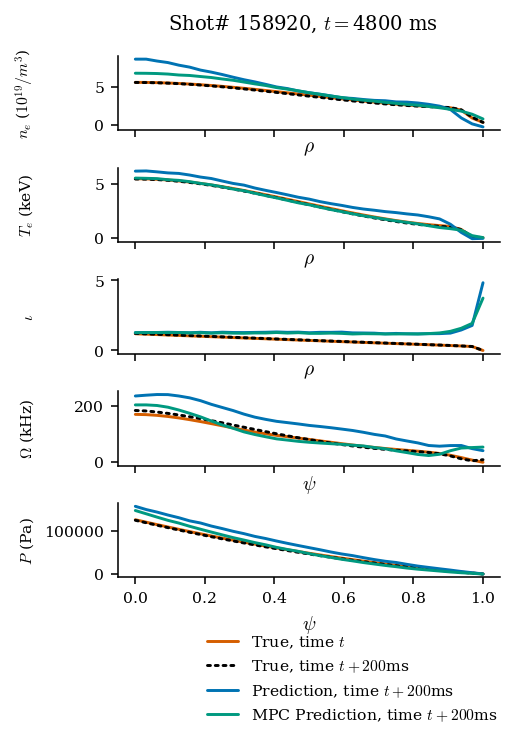

In [54]:
def get_model_prediction(x0, control_inputs, u_mpc, A, B, n):
    state_pred_arr = []
    mpc_pred_arr = []
    x_mpc = x0
    # Propagate through model
    for i in range(0, n):
        if (control_inputs is not None):
#         x0 = (A @ x0  + B @ control_inputs[i])
            x0 = (x0 @ A.T  + control_inputs[i] @ B.T)
            state_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x0)))
        if (u_mpc is not None):
            x_mpc = (x_mpc @ A.T  + u_mpc[i] @ B.T)
            mpc_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x_mpc)))

    # print("State_predictions: {}".format(state_predictions))
    return state_pred_arr, mpc_pred_arr

# Plotting
def generate_profile_plots(state_predictions, mpc_predictions, state_inputs, profiles, filtered = False, mpc_filtered = False):
    shotnum = generator.cur_shotnum[0,0]
    shottime = generator.cur_times[0,-scenario['lookahead']-1]
    psi = np.linspace(0,1,scenario['profile_length'])

    fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
    for j, profile in enumerate(profiles):
        ax = axes[j]

        inp = state_inputs[profile][0].squeeze()
        true = state_inputs[profile][-1].squeeze()
        
        inp = helpers.normalization.denormalize_arr(inp,scenario['normalization_dict'][profile])
        true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])
        
        ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
        ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
        
        if (state_predictions is not None):
            if (filtered == True):
                pred = butter_lowpass_filtfilt(state_predictions[profile].squeeze(), cutoff, fs)
            else:
                pred = (state_predictions[profile].squeeze())
#             print(pred)
            pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])
            ax.plot(psi,pred,lw=1.5,label='Prediction, time $t+200$ms',c=colorblind_colors[0])
        
        if (mpc_predictions is not None):
            if (mpc_filtered == True):
                mpc_pred = butter_lowpass_filtfilt(mpc_predictions[profile].squeeze(), cutoff, fs)
            else:
                mpc_pred = (mpc_predictions[profile].squeeze())
            mpc_pred = helpers.normalization.denormalize_arr(mpc_pred,scenario['normalization_dict'][profile])
            ax.plot(psi,mpc_pred,lw=1.5,label='MPC Prediction, time $t+200$ms',c=colorblind_colors[2])

        ax.set_ylabel(labels[profile],size=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if j in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if j in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
    fig.align_ylabels(axes)
    plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
    fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
    fig.legend(handles=axes[0].lines,     
               labels=[line._label for line in axes[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.12),
               frameon=False,
               mode=None,
               ncol=1,
              fontsize=8)

    
index = 55
n = scenario['lookahead']
profiles = scenario['profile_names']
temp_x = enc_x[index]
temp_u = enc_inputs[index]

N = temp_x.shape[0]
M = enc_inputs.shape[2]

# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-10

# Run MPC
sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,enc_XF[index],n)
sol_mpc = np.array(sol_mpc['x'])
temp_u_mpc = sol_mpc.reshape(n, M)

# temp_u_mpc = None
# mpc_pred = None
# print("A.shape: {}".format(A.shape))
# print("B.shape: {}".format(B.shape))
# print("temp_x.shape: {}".format(temp_x.shape))

state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)

# state_pred[n-1]['dens'].shape

generate_profile_plots(state_pred[n-1], mpc_pred[n-1], state_inputs_arr[index], profiles, filtered = False)

In [ ]:
scenario['lookahead']

In [55]:
scenario['invert_q']

True

### Using model.predict

In [ ]:

# good_indices = [5085,8351,1749,10746,7299,479,9980,5878,1297,12951]
good_indices = [4851,6074,7645,765,2267,4715]
psi = np.linspace(0,1,scenario['profile_length'])
# index = good_indices[0]
# index = np.random.randint(len(generator))

print("Index: {}".format(index))
inputs, targets,_ = generator[index]
profiles = scenario['profile_names']#['dens','temp','rotation','q_EFIT02','press_EFIT02']

shotnum = generator.cur_shotnum[0,0]
shottime = generator.cur_times[0,-scenario['lookahead']-1]

predictions=model.predict_on_batch(inputs)
# print(np.array(predictions)[0].shape)

fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
for j, profile in enumerate(profiles):
    ax = axes[j]
    predictions_smooth = butter_lowpass_filtfilt(predictions[0][-1][j*33:(j+1)*33].squeeze(), cutoff, fs)
    inp = inputs['input_{}'.format(profile)][0][0].squeeze()
    true = inputs['input_{}'.format(profile)][0][-1].squeeze()
    pred = predictions[0][-1][j*33:(j+1)*33].squeeze()
#     pred = predictions_smooth #+ inputs['input_{}'.format(profile)][0][-1].squeeze()
    
    inp = helpers.normalization.denormalize_arr(inp,scenario['normalization_dict'][profile])
    true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])
    pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])
    
# print(inputs['input_{}'.format(profiles[0])][0])
    ### Plotting code after this point
    
    ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
    ax.plot(psi,true,lw=1.5,label='True, time $t+300$ms',c='k',ls=':')
    ax.plot(psi,pred,lw=1.5,label='Prediction, time $t+300$ms',c=colorblind_colors[0])

    ax.set_ylabel(labels[profile],size=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #ax.set_xticks([0,.5,1])
    #ax.set_xlim(0,1)
    if j in [0,1,2]:
        ax.set_xlabel('$\\rho$',size=10)
    if j in [3,4]:
        ax.set_xlabel('$\psi$',size=10)
fig.align_ylabels(axes)
plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
fig.legend(handles=axes[0].lines,     
           labels=[line._label for line in axes[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.12),
           frameon=False,
           mode=None,
           ncol=1,
          fontsize=8)

## Test Encoding Error

In [ ]:


# Data
temp_x2 = generator.get_data_by_shot_time([158920],None)[0]
temp_x = {}

prob_key = []
for key in temp_x2:
    if (temp_x2[key].shape[-1] == 33):
        temp_x[key]= np.array([[temp_x2[key][0][0]]])

# Encode and decode
temp_x_prime = state_decoder.predict(np.squeeze(state_encoder.predict(temp_x))[np.newaxis,:])

tempor = np.array([])
for keys in temp_x:
    tempor = np.concatenate([tempor,temp_x[keys][0][0]])
    
temp_x_fil = []
for i in range(0, int(len(temp_x_prime[0])/33)):
#     temp_x_fil.append(butter_lowpass_filtfilt(temp_x_prime[0][i*33:(i+1)*33].squeeze(), cutoff, fs))   
    temp_x_fil.append(temp_x_prime[0][i*33:(i+1)*33].squeeze())

temp_x_fil = np.concatenate(temp_x_fil)

# plt.plot(temp_x_prime.flatten())

# plt.plot(tempor)
# plt.plot((temp_x_fil),color = 'black')
# plt.legend(['Encoded','Original','Filtered'])
# plt.show()


figures, axes = plt.subplots(nrows = 5, ncols = 1)

for j in range(0, 5):
#     axes[j].plot(temp_x_prime.flatten()[j*33:(j+1)*33])
    axes[j].plot(tempor[j*33:(j+1)*33])
    axes[j].plot(temp_x_fil[j*33:(j+1)*33], color = 'black')
    axes[j].set_ylabel("Profile")
    axes[j].set_xlabel("Discrete Space")
#     figures.tight_layout()
figures.legend([ "Original Profile", "Filtered Encoded Profile"])
plt.show()
figures.clear()


In [ ]:
# A simple experiment to obtain error percentages in encoding and decoding of states

# n_sample goes from 0 to 9701 and only accepts even integers
n_sample = 4

if (n_sample % 2 != 0):
    sys.exit("n_sample must be even and > 2")
sample = []

# pick n_samples at random
for i in range(0, n_sample):
    sample.append(np.random.randint(9700))

# print(sample)
    
percent_err_tot = []
temp_x_tot = []
tempor_tot = []
temp_x_filtered = []
percent_err_mean = []

for samp in sample:
    temp_x = x[samp]
    
#     print(temp_x)
    
    # Encode and decode state
    temp_x_prime = state_decoder.predict(np.squeeze(state_encoder.predict(x[samp]))[np.newaxis,:])
    
    tempor = np.array([])
    for keys in x[samp]:
        tempor = np.concatenate([tempor,x[samp][keys][0][0]])
    
    percent_err = abs(100*((tempor - temp_x_prime))/(tempor))
    percent_err_tot.append(percent_err)
    percent_err_mean.append(np.mean(percent_err))
    temp_x_tot.append(temp_x_prime)
    tempor_tot.append(tempor)
    
    temp_x_fil = []
    for i in range(0, int(len(temp_x_prime[0])/33)):
        temp_x_fil.append(butter_lowpass_filtfilt(temp_x_prime[0][i*33:(i+1)*33].squeeze(), cutoff, fs))    
    temp_x_filtered.append(np.concatenate(temp_x_fil))
    
    
print("Mean Sample Error of States: {} %".format(np.mean(percent_err_mean)))


n_fig = 2
figures, axes = plt.subplots(nrows = int(len(sample) /2), ncols = n_fig)

for i in range(0, n_fig):
    for j in range(0, int(len(sample) /2)):
        axes[j,i].plot(temp_x_tot[j*(n_fig)+i].flatten())
        axes[j,i].plot(tempor_tot[j*(n_fig)+i])
        axes[j,i].plot(temp_x_filtered[j*(n_fig)+i], color = 'black')
        axes[j,i].set_ylabel("Profile")
        axes[j,i].set_xlabel("Discrete Space")
#     figures.tight_layout()
figures.legend(["Encoded Profile", "Original Profile", "Filtered Encoded Profile"])
plt.show()
figures.clear()

# np.concatenate(temp_x_filtered[0])
# butter_lowpass_filtfilt(temp_x_prime[0][i*33:(i+1)*33].squeeze(),cutoff,fs)

In [ ]:
### THIS CANNOT BE IMPLEMENTED IN THIS MODEL

# A similar experiment to obtain error percentages in encoding and decoding of inputs

# Sample goes from 0 to 9701
n_sample = 6
sample = []

# pick n_samples at random
for i in range(0, n_sample):
    sample.append(np.random.randint(100))

percent_err_tot = []
tempor_tot = []
temp_u_prime_tot = []
percent_err_mean = []

for samp in sample:
    temp_inp = inputs[samp]
    
    # encode control
    T = scenario['lookback'] + scenario['lookahead']
    temp_u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in temp_inp.items()}
#         print(temp_input)
        temp_u.append(np.squeeze(control_encoder.predict(temp_input)))
    
    # Decode control
    temp_u_prime = np.concatenate(decode_inputs(control_decoder, np.array(temp_u)))
    
    tempor = np.array([])
    tempor2 = []
    for keys in inputs[samp]:
        tempor2.append(np.transpose(inputs[samp][keys][0])[0])
    
    for i in range(0,len(tempor2[0])):
        tempor = np.concatenate([tempor,np.squeeze(np.array([tempor2[j][i] for j in range(len(tempor2))]))])

    percent_err = abs(100*((tempor - temp_u_prime))/(tempor))
    percent_err_tot.append(percent_err)
    temp_u_prime_tot.append(temp_u_prime)
    tempor_tot.append(tempor)
    percent_err_mean.append(np.mean(percent_err))
    
print("Mean Sample Error of Control Inputs: {} %".format(np.mean(percent_err_mean)))
# plt.plot(tempor)
# plt.plot(temp_u_prime)

n_fig = 2
figures, axes = plt.subplots(nrows = int(len(sample) /2), ncols = n_fig)

for i in range(0, n_fig):
    for j in range(0, int(len(sample) /2)):
        axes[j,i].plot(temp_u_prime_tot[j*(n_fig)+i].flatten())
        axes[j,i].plot(tempor_tot[j*(n_fig)+i])
        axes[j,i].set_ylabel("Control Input")
        axes[j,i].set_xlabel("Discrete Time")
#     figures.tight_layout()
figures.legend(["Encoded Profile", "Original Profile"])
plt.show()
figures.clear()

## Neo MPC System

In [12]:
def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    from scipy.linalg import solve_discrete_are
    return solve_discrete_are(A, B, Q, R) 

def solve_Neo_MPC_system(Q,R,A,B,x0,xf,n):
    
    # Imports
    import numpy
    from cvxopt import matrix
    from cvxopt import solvers
    
    # Define parameters
    N = A.shape[0]
    M = B.shape[1]
    print("N: {}".format(N))
    print("M: {}".format(M))
    
    # Reshape to avoid complications
    x0 = x0.reshape((N,1))
    xf = xf.reshape((N,1))

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]
    
#     print("M_bar: {}".format(M_bar))
    
    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n-1):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]
    
    Q_N = lqr(A,B,Q,R)
    rsl = slice((n-1) * N, n * N)
    Q_bar[rsl, rsl] = Q_N
    
#     print("Q_bar: {}".format(Q_bar))

    # Generate R_bar
    R_bar = np.kron(np.eye(n),R)
    
#     print("R_bar: {}".format(R_bar))

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
    
#     print("V: {}".format(V))
        
    # Generate L
    L = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    L[rsl, :N] = A #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        L[rsl, :N] = L[rsl_p, :N]
        L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]
    
#     print("L: {}".format(np.matrix.view(L)))
    
    #Generate X_F from x_f
    X_F = np.zeros((N*n,1))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
    
#     print("XF: {}".format(X_F))
    
    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on U
    lim = 1
    
    d[rsl,:] = np.ones((M*n,1))*lim
    d[slice(M*n,2*M*n),:] = np.ones((M*n,1))*lim

#     print("D_bar: {}".format(D_bar))
#     print("D: {}".format(d))
    
    # Generate F and H matrices   
    temp = np.transpose(V) @ (Q_bar)
    F = temp @ (M_bar.dot(x0) - X_F) # + L @ (X_F)
    
    temp = np.transpose(V) @ (Q_bar)
    H = temp @ (V) + R_bar
    
#     print("H: {}".format(H))
#     print("F: {}".format(F))

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)

    P = matrix(H, tc='d')
    q = matrix(F, tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')

    ######################################### Print Solution ###############################
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q, G, h)

    return sol

## Solve MPC Problem for one case

### Set up Q,R

In [27]:
# 0 <= Sample < 9701
sample = 10

x0 = enc_x[sample] 
xf = enc_XF[sample]

N = x0.shape[0]
M = enc_inputs.shape[2]

# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-3

# Replenish A,B
A,B = get_AB(model)

n = scenario['lookback'] + scenario['lookahead']
print("N: {}".format(N))
print("M: {}".format(M))
print("n: {}".format(n))
print("Q: {}".format(np.matrix.view(Q)))
print("R: {}".format(np.matrix.view(R)))

N: 70
M: 4
n: 4
Q: [[100000.      0.      0. ...      0.      0.      0.]
 [     0. 100000.      0. ...      0.      0.      0.]
 [     0.      0. 100000. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ... 100000.      0.      0.]
 [     0.      0.      0. ...      0. 100000.      0.]
 [     0.      0.      0. ...      0.      0. 100000.]]
R: [[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]


### Solve System

In [28]:
sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x0,xf,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(n, M)
u_mpc

N: 70
M: 4
     pcost       dcost       gap    pres   dres
 0: -3.1877e+01 -8.8407e+01  1e+02  1e+00  3e-16
 1: -2.9576e+01 -4.7467e+01  2e+01  4e-16  2e-16
 2: -3.1387e+01 -3.3896e+01  3e+00  3e-16  2e-16
 3: -3.2015e+01 -3.2255e+01  2e-01  2e-16  2e-16
 4: -3.2085e+01 -3.2098e+01  1e-02  3e-16  2e-16
 5: -3.2089e+01 -3.2090e+01  8e-04  2e-16  3e-16
 6: -3.2089e+01 -3.2089e+01  4e-05  2e-16  2e-16
 7: -3.2089e+01 -3.2089e+01  5e-07  2e-16  2e-16
Optimal solution found.


array([[ 1.        ,  1.        ,  0.40226131,  0.99999999],
       [ 1.        ,  1.        , -0.74232864, -0.54921562],
       [ 0.99999999,  1.        , -0.99998163, -0.73849729],
       [ 0.57233575,  1.        , -0.6866023 , -0.2750693 ]])

### Actual inputs

In [29]:
enc_inputs[sample]

array([[0.23182273, 0.20983121, 0.34492674, 0.24509096],
       [0.2224923 , 0.23442239, 0.3750411 , 0.24232346],
       [0.23212937, 0.20893194, 0.3438662 , 0.24521682],
       [0.2225077 , 0.23448125, 0.37506875, 0.24228999]], dtype=float32)

## Plots

### Plot u vs time

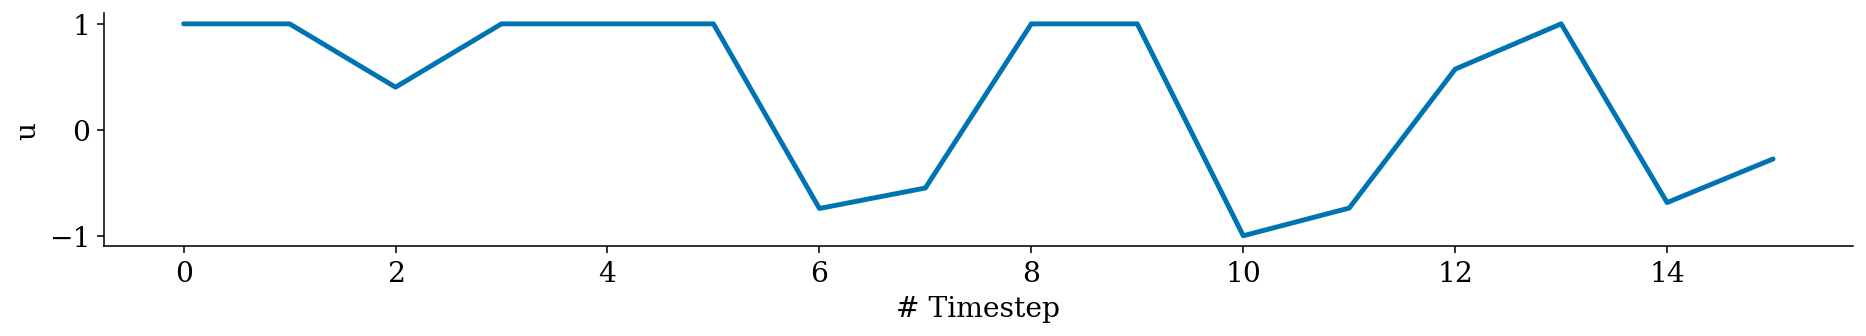

In [30]:
plt.plot(sol_mpc)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("u")
plt.xlabel("# Timestep")
plt.show()

### Plot how state changes

In [31]:
states = []
abs_diff = []
abs_fin_diff = []
abs_aut_diff = []
x_prev = x0
x_prev2 = x0

for i in range(0,n):
    x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[i]))
    x_new2 = (A @ x_prev2) + np.transpose(B.dot(enc_inputs[sample][i]))    
    
#     print("x[{}]: {} \n".format(i+1,x_new))

    states.append(x_prev)
    abs_diff.append(np.linalg.norm(x_new - x_prev))
    abs_fin_diff.append(np.linalg.norm(x_new - xf))
    abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
    x_prev = x_new
    x_prev2 = x_new2

print("Target: {} \n".format(xf))
    

Target: [ 5.2497117e-03  8.6406097e-03  2.0187907e-03  9.4124582e-03
 -8.1199408e-04 -4.1597486e-03  9.3860002e-03  8.6523043e-03
 -3.8600087e-02  3.5052817e-02  7.4508879e-03 -5.1422715e-03
  9.0840198e-03 -5.0742030e-03  1.0837444e-02  7.9541467e-05
 -2.1596313e-02  1.4046581e-02 -1.0602653e-02 -1.5002668e-02
 -2.7066708e-02 -1.0836720e-03 -4.8581481e-02 -2.7073145e-02
 -6.7041576e-02  1.5024994e-02 -1.0073185e-04  2.8533647e-03
  9.8222038e-03 -6.2260628e-03 -1.6492009e-03 -3.9995015e-02
  1.1869182e-02  3.1645902e-02  1.5854416e-04 -4.0509105e-03
  4.8806099e-03  1.3429578e-04  3.2262940e-02  6.1939787e-03
  3.5566795e-03  9.8885186e-03 -6.0417056e-02 -2.8266132e-02
  5.4859039e-03  1.1726777e-02 -3.8319290e-02 -1.6190350e-02
 -1.8893361e-02  6.2397793e-03 -2.2588491e-02 -4.2105675e-02
 -3.3978701e-02  2.4736188e-02  1.3678856e-03  1.9527923e-03
 -2.1780729e-02  1.4738436e-02 -2.6534200e-03 -7.9196692e-04
  2.1263011e-02 -7.4929595e-03  1.8995630e-02  1.8935151e-02
 -2.0144582e-02 

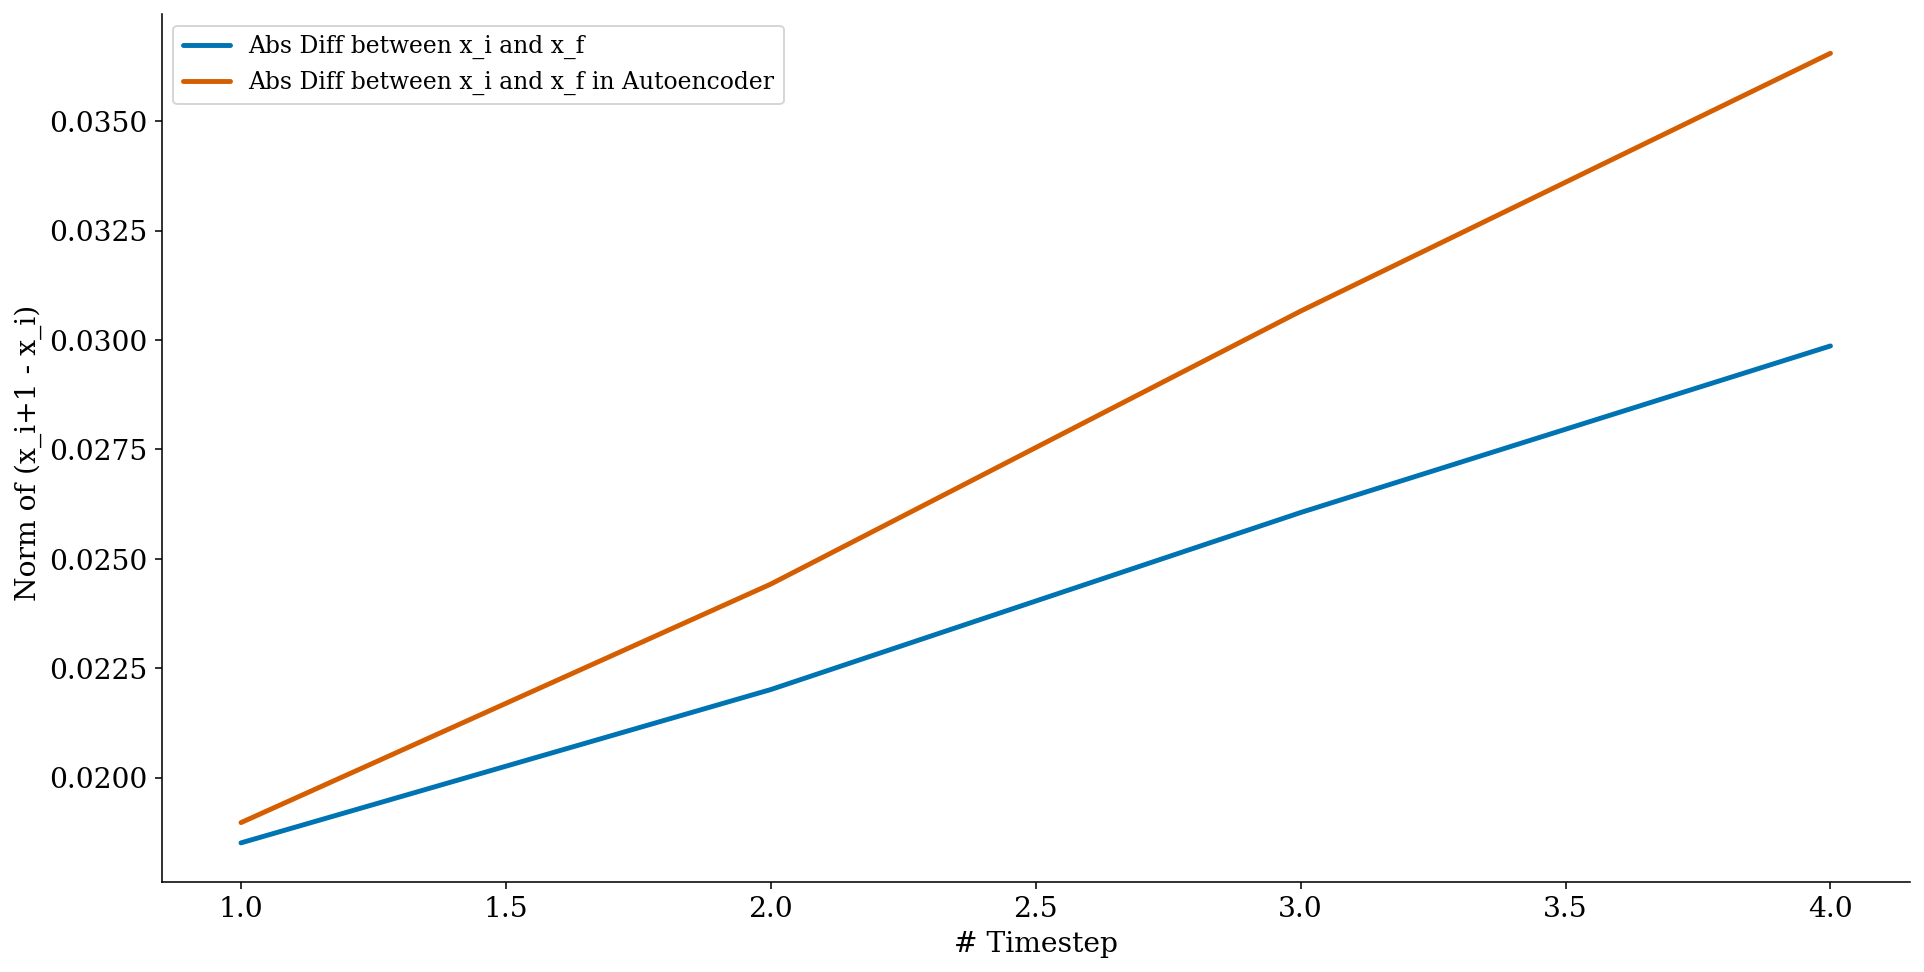

In [32]:
plt.clf()
plt.plot(np.arange(1,n+1),abs_fin_diff)
plt.plot(np.arange(1,n+1),abs_aut_diff)
plt.legend(["Abs Diff between x_i and x_f", "Abs Diff between x_i and x_f in Autoencoder"])
plt.ylabel("Norm of (x_i+1 - x_i) ")
plt.xlabel("# Timestep")
plt.show()

# Generate Larger results

In [37]:
# Generate Q,R
Q = np.eye(N)*1e1
rsl = slice(0, int(N/5))
Q[rsl, rsl] = np.eye(int(N/5))*1e2
# rsl = slice(40, 60)
# Q[rsl, rsl] = np.eye(20)*1e3

# R = np.eye(M)*1e1
R = np.eye(M)*1e-5

# Replenish A,B
A,B = get_AB(model)

n = scenario['lookahead']

#### Pick Sample and solve system
index = 55 #8716
# 0 <= Sample < 9701
# Pick n_sample random samples and put them into an array called sample
# n_sample = 8
sample = [index]

# for i in range(0, n_sample):
#     sample.append(np.random.randint(100))

# Solve mpc system for the samples in sample array
u_mpc = []
for samp in sample:
    x0 = enc_x[samp] 
    xf = enc_XF[samp]

    N = x0.shape[0]
    M = enc_inputs.shape[2]

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x0,xf,n)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc.append(sol_mpc.reshape(n, M))
u_mpc = np.array(u_mpc)

# Generate statistics for each sample
# abs_diff_tot = []
# abs_aut_diff_tot = []

# for j in range(0,len(sample)):
#     states = []
#     abs_diff = []
#     abs_aut_diff = []
#     x_prev = enc_x_fil[sample[j]]
#     x_prev2 = enc_x_fil[sample[j]]
#     xf = enc_XF[sample[j]] ### IMPORTANT

#     for i in range(0,n):
#         x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[j][i]))
#         x_new2 = (A @ x_prev2) + np.transpose(B.dot(enc_inputs[sample[j]][i]))    

#         states.append(x_prev)
#         abs_diff.append(np.linalg.norm(x_new - xf))
#         abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
#         x_prev = x_new
#         x_prev2 = x_new2
#     abs_diff_tot.append(abs_diff)
#     abs_aut_diff_tot.append(abs_aut_diff)


# n_fig = 2
# figures, axes = plt.subplots(nrows = int(len(sample) /2), ncols = n_fig, clear= True)

# for i in range(0, n_fig):
#     for j in range(0, int(len(sample) /2)):
#         axes[j,i].plot(abs_diff_tot[j*(n_fig)+i])
#         axes[j,i].plot(abs_aut_diff_tot[j*(n_fig)+i])
#         axes[j,i].set_ylim([0,np.max(np.concatenate([abs_aut_diff_tot[j*(n_fig)+i],abs_diff_tot[j*(n_fig)+i]]))])
#         axes[j,i].set_ylabel("||x_i+1 - x_f|| ")
#         axes[j,i].set_xlabel("# Timestep")
# # figures.tight_layout()
# figures.legend(["||x_i - x_f||", "||x_i - x_f|| in Autoencoder"])
# plt.show()
# figures.clear()

N: 70
M: 4
     pcost       dcost       gap    pres   dres
 0: -2.7914e-05 -3.2065e+01  3e+01  5e-17  3e-16
 1: -8.2139e-05 -3.8371e-01  4e-01  2e-16  8e-16
 2: -2.0794e-03 -3.3781e-02  3e-02  2e-16  7e-17
 3: -3.9691e-03 -8.1583e-03  4e-03  2e-16  7e-18
 4: -4.8216e-03 -5.4415e-03  6e-04  2e-16  9e-19
 5: -5.0190e-03 -5.0833e-03  6e-05  2e-16  8e-19
 6: -5.0487e-03 -5.0515e-03  3e-06  3e-16  1e-18
 7: -5.0504e-03 -5.0504e-03  3e-08  2e-16  1e-18
Optimal solution found.


In [38]:
scenario['profile_names']
enc_x[0].shape
1e3

1000.0

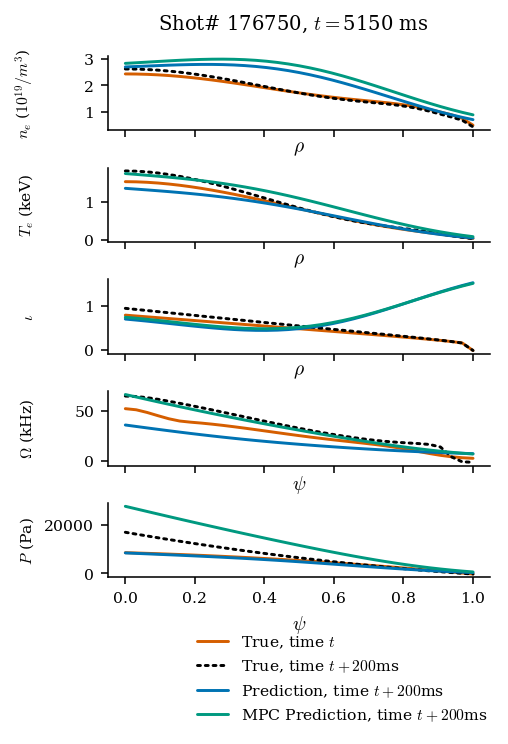

In [40]:
n = scenario['lookahead']
profiles = scenario['profile_names']
temp_x = enc_x[index]
temp_u = enc_inputs[index]
temp_u_mpc = u_mpc[0]

state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
generate_profile_plots(state_pred[n-1], mpc_pred[n-1], state_inputs_arr[index], profiles, filtered = True, mpc_filtered = True)

### Interpretation of Encoded state MPC results

The MPC is asked to find the set of control inputs $ U $ which take the state space system from some $x_i$ to some $x_f$, both of which are taken from real data. However, the state space model used by the MPC relies on the model used from the autoencoder system. 

The autoencoder model predicts some final state $x_f^a$ based on the actual set of inputs used during the experiment.

The MPC's final state $x_f^m$ is in fact closer to the real state $x_f$ than $x_f^a$.

There are numerous possibilities:

1. There  are errors in the state space model from the autoencoder, which implies that the real set of inputs to reach $x_f$ are different from $U$.

2. The autoencoder's prediction $x_f^a$ in incorrect, and that the real state reached should be closer to $x_f$.

3. Both of the above?




## Other parameters

In [ ]:
# Test Controllability

# A = np.array([[1,0,0],[0,1,0],[0,0,-1]])
# B = np.array([[1],[2],[3]])

A,B = get_AB(model)

A_round = np.around(A, decimals = 2)
B_round = np.around(B, decimals = 2)

N = A.shape[0]
M = B.shape[1]

print("N: {}".format(N))
print("M: {}".format(M))

C = np.zeros([N, M*N])
rsl = slice(0,N)

C[rsl, 0:M] = B_round
for i in range(1,N):
    C[rsl, (M*i):(M*(i+1))] = A_round @ C[rsl, (M*(i-1)):(M*(i))]
    
C_round = np.around(C, decimals = 4)
print("Rank of C: {}".format(np.linalg.matrix_rank(C_round)))
print("Shape of C: {}".format(C.shape))
C_round

In [ ]:
# AB is 100 x 15
np.around([123.123456,123.123456], decimals = 3)

# ETC

In [ ]:
with open(scenario_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

with open('/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2_params.pkl', 'rb') as f:
    scenario_2 = pickle.load(f, encoding='latin1')

with open('/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0_params.pkl', 'rb') as f:
    scenario_aa = pickle.load(f, encoding='latin1')
    
scenario.keys()


In [ ]:
print("state_encoder_kwargs: {}".format(scenario_2['state_encoder_kwargs']))
print("control_encoder_kwargs: {}".format(scenario_2['control_encoder_kwargs']))
print("raw_data_path: {}".format(scenario_2['raw_data_path']))
print("x_weight: {}".format(scenario_2['x_weight']))
print("u_weight: {}".format(scenario_2['u_weight']))
print("state_latent_dim: {}".format(scenario_2['state_latent_dim']))

In [ ]:
print("state_encoder_kwargs: {}".format(scenario['state_encoder_kwargs']))
print("control_encoder_kwargs: {}".format(scenario['control_encoder_kwargs']))
print("raw_data_path: {}".format(scenario['raw_data_path']))
print("x_weight: {}".format(scenario['x_weight']))
print("u_weight: {}".format(scenario['u_weight']))
print("state_latent_dim: {}".format(scenario['state_latent_dim']))

In [ ]:
print("state_encoder_kwargs: {}".format(scenario_aa['state_encoder_kwargs']))
print("control_encoder_kwargs: {}".format(scenario_aa['control_encoder_kwargs']))
print("raw_data_path: {}".format(scenario_aa['raw_data_path']))
print("x_weight: {}".format(scenario_aa['x_weight']))
print("u_weight: {}".format(scenario_aa['u_weight']))
print("state_latent_dim: {}".format(scenario_aa['state_latent_dim']))